In [ ]:
import zipfile
import os


zip_file_path = '//content/mel_spectrograms.zip'
extract_path = '//content/mel_spectrograms'


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


extracted_files = os.listdir(extract_path)
extracted_files

['hungry', 'burping', 'belly_pain', 'tired', 'discomfort']

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
base_dir = "/content/mel_spectrograms"
train_dir = "/content/train"
test_dir = "/content/test"


os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


split_ratio = 0.8


for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)

 
    if os.path.isdir(class_path):
        print(f"Processing class: {class_name}")

       
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        if not files: 
            print(f"Skipping empty folder for class: {class_name}")
            continue

        
        train_files, test_files = train_test_split(files, train_size=split_ratio, random_state=42)

       
        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

       
        for file in train_files:
            src_path = os.path.join(class_path, file)
            dest_path = os.path.join(train_class_dir, file)
            shutil.copy(src_path, dest_path)

       
        for file in test_files:
            src_path = os.path.join(class_path, file)
            dest_path = os.path.join(test_class_dir, file)
            shutil.copy(src_path, dest_path)

print("Data successfully split into train and test folders!")


Processing class: hungry
Processing class: burping
Processing class: belly_pain
Processing class: tired
Processing class: discomfort
Data successfully split into train and test folders!


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
img_height = 200
img_width = 500

batch_size = 32

train_dir = "/content/train"
test_dir = "/content/test"


train_datagen = ImageDataGenerator(
    rescale=1.0/255,               
     validation_split=0.2,     )    



test_datagen = ImageDataGenerator(
    rescale=1.0/255,
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)


val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



Found 442 images belonging to 5 classes.
Found 108 images belonging to 5 classes.
Found 140 images belonging to 5 classes.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import numpy as np

class_counts = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_counts), y=class_counts)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)



Class weights: {0: 1.7333333333333334, 1: 2.4555555555555557, 2: 1.5241379310344827, 3: 0.3622950819672131, 4: 1.6679245283018869}


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2


model = Sequential([
    Conv2D(24, (5, 5), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((4, 2)),


    Conv2D(48, (5, 5), activation='relu'),
    MaxPooling2D((4, 2)),


    Conv2D(48, (5, 5), activation='relu'),



    Flatten(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(train_generator.num_classes, activation='softmax')  
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

epochs = 20
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, class_weight=class_weights_dict)


Epoch 1/20
14/14 [==============================] - 15s 983ms/step - loss: 1.7179 - accuracy: 0.4321 - val_loss: 1.6031 - val_accuracy: 0.5093
Epoch 2/20
14/14 [==============================] - 13s 934ms/step - loss: 1.6031 - accuracy: 0.5158 - val_loss: 1.5940 - val_accuracy: 0.3426
Epoch 3/20
14/14 [==============================] - 13s 929ms/step - loss: 1.5716 - accuracy: 0.4864 - val_loss: 1.2525 - val_accuracy: 0.5741
Epoch 4/20
14/14 [==============================] - 13s 924ms/step - loss: 1.4783 - accuracy: 0.4027 - val_loss: 1.3881 - val_accuracy: 0.4074
Epoch 5/20
14/14 [==============================] - 13s 925ms/step - loss: 1.2708 - accuracy: 0.4751 - val_loss: 1.4134 - val_accuracy: 0.3704
Epoch 6/20
14/14 [==============================] - 13s 929ms/step - loss: 1.1843 - accuracy: 0.5430 - val_loss: 1.3479 - val_accuracy: 0.4815
Epoch 7/20
14/14 [==============================] - 13s 931ms/step - loss: 0.9136 - accuracy: 0.5792 - val_loss: 1.2231 - val_accuracy: 0.6389

In [ ]:

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"test accuracy: {test_accuracy:.2f}")

model.save('/content/2dC_cnn.h5')


5/5 [==============================] - 2s 331ms/step - loss: 0.0087 - accuracy: 1.0000
test accuracy: 1.00


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
from itertools import cycle


In [ ]:

y_prob = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(y_prob, axis=1)


y_true_bin = label_binarize(y_true, classes=np.arange(train_generator.num_classes))


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step


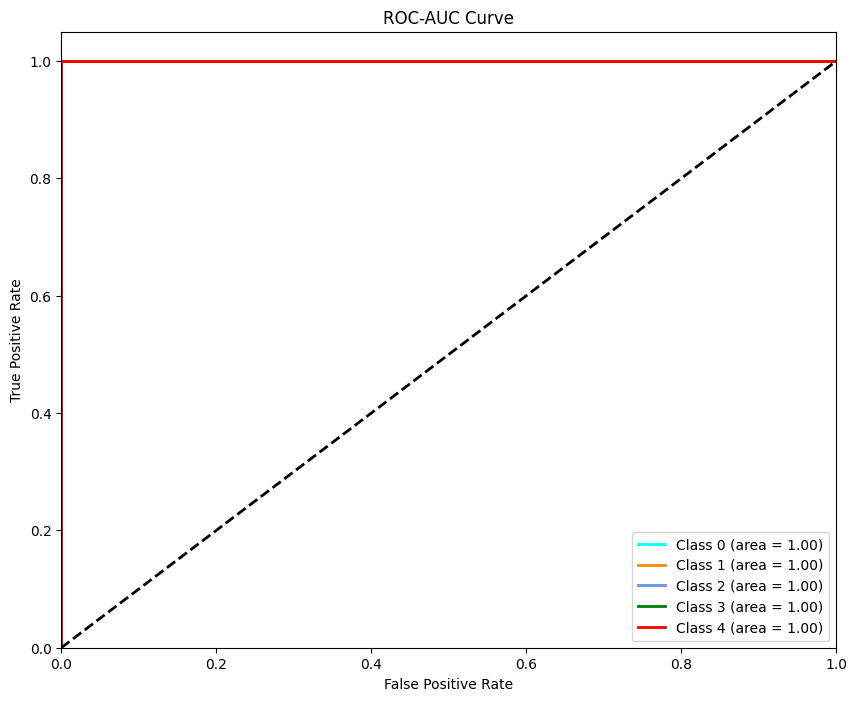

In [ ]:

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])


for i, color in zip(range(train_generator.num_classes), colors):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc="lower right")
plt.show()


<Figure size 800x600 with 0 Axes>

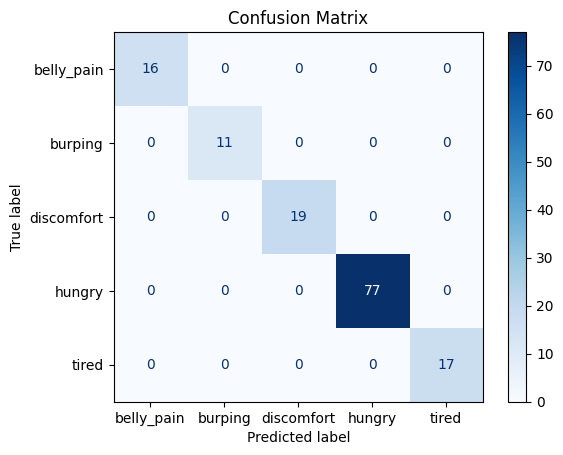

In [ ]:

cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report


report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())


print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

  belly_pain       1.00      1.00      1.00        16
     burping       1.00      1.00      1.00        11
  discomfort       1.00      1.00      1.00        19
      hungry       1.00      1.00      1.00        77
       tired       1.00      1.00      1.00        17

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140



In [ ]:
import pickle
from tensorflow.keras.models import load_model

class CNNModelWrapper:
    def __init__(self, model):
        self.model = model

    def save(self, model_path):
        """Save the CNN model to an HDF5 file."""
        self.model.save(model_path)

    @staticmethod
    def load(model_path):
        """Load the CNN model from an HDF5 file."""
        return load_model(model_path)


cnn_wrapper = CNNModelWrapper(model)


with open('2dcnn_model.pkl', 'wb') as f:
    pickle.dump(cnn_wrapper, f)
print("CNN model saved successfully in pickle format.")


CNN model saved successfully in pickle format.


Model two custom cnn architecture

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    # Dropout(0.1),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),


    Flatten(),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(train_generator.num_classes, activation='softmax')  
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

epochs = 20
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, class_weight=class_weights_dict)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.1520 - loss: 6.2861 - val_accuracy: 0.5463 - val_loss: 2.0902
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 419ms/step - accuracy: 0.4277 - loss: 2.0834 - val_accuracy: 0.5833 - val_loss: 2.0966
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 308ms/step - accuracy: 0.4304 - loss: 2.0022 - val_accuracy: 0.5185 - val_loss: 2.0408
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step - accuracy: 0.4130 - loss: 2.0957 - val_accuracy: 0.5556 - val_loss: 1.9648
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 409ms/step - accuracy: 0.4357 - loss: 2.0805 - val_accuracy: 0.4352 - val_loss: 1.8988
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step - accuracy: 0.4703 - loss: 1.9037 - val_accuracy: 0.4259 - val_loss: 1.8134
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 315ms/step - accuracy: 0.3588 - loss: 1.9320 - val_accuracy: 0.5185 - val_loss: 1.7793
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 412ms/step - accuracy: 0.5613 - loss: 1.6956 - val_accuracy: 0.

In [ ]:

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"test accuracy: {test_accuracy:.2f}")


# model.save('/content/audio_classification_cnn.h5')


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - accuracy: 1.0000 - loss: 0.2070
test accuracy: 1.00


In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
from itertools import cycle


In [ ]:

y_prob = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(y_prob, axis=1)


y_true_bin = label_binarize(y_true, classes=np.arange(train_generator.num_classes))


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step


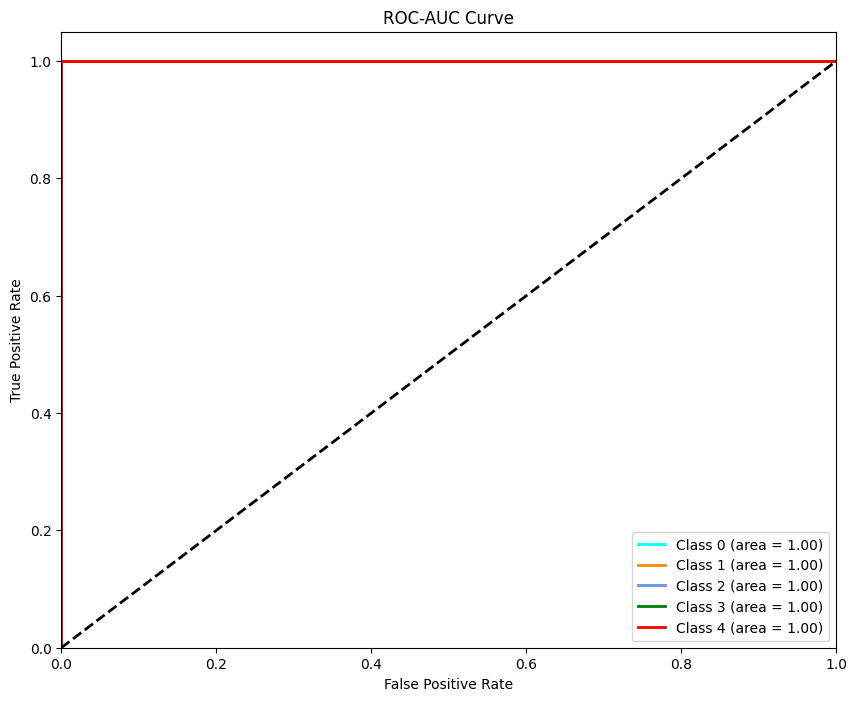

In [ ]:

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])


for i, color in zip(range(train_generator.num_classes), colors):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc="lower right")
plt.show()


<Figure size 800x600 with 0 Axes>

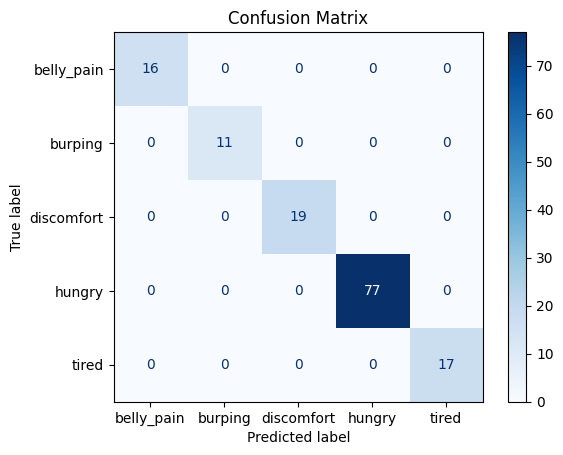

In [ ]:

cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pickle
from tensorflow.keras.models import load_model

class CNNModelWrapper:
    def __init__(self, model):
        self.model = model

    def save(self, model_path):
        """Save the CNN model to an HDF5 file."""
        self.model.save(model_path)

    @staticmethod
    def load(model_path):
        """Load the CNN model from an HDF5 file."""
        return load_model(model_path)


cnn_wrapper = CNNModelWrapper(model)


with open('cnn_model2.pkl', 'wb') as f:
    pickle.dump(cnn_wrapper, f)
print("cnn model saved successfully in pickle format.")


cnn model saved successfully in pickle format.
